In [ ]:
# %%

# Step 1: Load and Clean Data
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1.1 Load the dataset
file_path = 'The_Student_Dataset.csv'
df = pd.read_csv(file_path)

# 1.2 Clean column names: remove leading/trailing spaces, replace spaces with underscores, remove non-alphanumeric characters
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
df.columns = df.columns.str.replace(r'\s+', '_', regex=True)  # Replace spaces with underscores
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove non-alphanumeric characters

# 1.3 Clean unique data: Standardize categories and remove extra spaces
def clean_column_data(column):
    column = column.str.strip()  # Remove leading/trailing spaces
    column = column.replace({
        'Y1': 'Grade 1', 'year1': 'Grade 1', 'grade 1': 'Grade 1', 'Year 1': 'Grade 1',
        'Y2': 'Grade 2', 'year2': 'Grade 2', 'grade 2': 'Grade 2', 'Year 2': 'Grade 2',
        'Y3': 'Grade 3', 'year3': 'Grade 3', 'grade 3': 'Grade 3', 'Year 3': 'Grade 3',
        'Y4': 'Grade 4', 'year3': 'Grade 4', 'grade 4': 'Grade 4', 'Year 4': 'Grade 4',
        'Y5': 'Grade 5', 'year5': 'Grade 5', 'grade 5': 'Grade 5', 'Year 5': 'Grade 5',
        'Y6': 'Grade 6', 'year6': 'Grade 6', 'grade 6': 'Grade 6', 'Grade 6 ': 'Grade 6', 'Year 6': 'Grade 6',
        'Y7': 'Grade 7', 'year7': 'Grade 7', 'grade 7': 'Grade 7', 'Grade 7 ': 'Grade 7', 'Year 7': 'Grade 7',
        'Y8': 'Grade 8', 'year8': 'Grade 8', 'grade 8': 'Grade 8', 'Grade 8 ': 'Grade 8',
        'Y9': 'Grade 9', 'year9': 'Grade 9', 'grade 9': 'Grade 9',
        'Y10': 'Grade 10', 'year10': 'Grade 10', 'grade 10': 'Grade 10', 'Year 10': 'Grade 10',
        'Y11': 'Grade 11', 'year11': 'Grade 11', 'grade 11': 'Grade 11',
        'Y12': 'Grade 12', 'year12': 'Grade 12', 'grade 12': 'Grade 12',
        'Y13': 'Grade 13', 'year13': 'Grade 13', 'grade 13': 'Grade 13',
        'Year System' : 'Year System', 'Year System ' : 'Year System',
        'Grade System' : 'Grade System', 'Grade system' : 'Grade System',
    }, regex=True)
    return column

# 1.4 Apply the cleaning function to all categorical columns
for col in df.columns:
    if df[col].dtype == 'object':  # Only clean non-numeric columns
        df[col] = clean_column_data(df[col])

# 1.5 Filter rows based on curriculum (only American and British)
valid_curricula = ['American', 'British']
df = df[df['Previous_Curriculum_17182'].isin(valid_curricula)]

# 1.6 Modify 'Year_of_Admission' based on 'Current_School' column
df['Year_of_Admission'] = df['Year_of_Admission'].replace({'School 1 Current Student':'Current Student'})
df['Year_of_Admission'] = df['Year_of_Admission'].replace({'School 2 Current Student':'Current Student'})

In [ ]:
# %%

# Step 2: Handle missing values: fill categorical with mode, numerical with mean
for col in df.columns:
    if df[col].isnull().sum() > 0:  # If there are null values in the column
        if df[col].dtype == 'object':  # For categorical columns (strings)
            mode_value = df[col].mode()[0]  # Get the most frequent value
            df[col].fillna(mode_value, inplace=True)
        else:  # For numerical columns
            mean_value = df[col].mean()  # Get the mean value
            df[col].fillna(mean_value, inplace=True)

<ipython-input-14-3478a13adb36>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_value, inplace=True)


In [ ]:
# %%

# Step 3: Encode Categorical Data to Numerical
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

# 3.1 Remove rows where 'Year_of_Admission' contains "New Admission 18/19"
df = df[df['Year_of_Admission'] != 'New Admission 18/19']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical to numerical
    label_encoders[col] = le  # Save the encoder for future reference

# Now just drop the column Year_of_Admission.
df.drop(columns=['Year_of_Admission'], inplace=True)
# 3.2 Save the preprocessed data and mappings
output_file_path = 'The_Student_Dataset_Preprocessed.xlsx'
mapping_data = []

for col, le in label_encoders.items():
    category_mapping = {index: label for index, label in enumerate(le.classes_)}
    mapping_data.append({"Column Name": col, "Mapping": category_mapping})

mapping_df = pd.DataFrame(mapping_data)

# 3.3 Write the cleaned data and mapping data to an Excel file
with pd.ExcelWriter(output_file_path) as writer:
    df.to_excel(writer, sheet_name='Data', index=False)
    mapping_df.to_excel(writer, sheet_name='Mappings')

print(f"Preprocessing complete. Dataset saved to: {output_file_path}")

Preprocessing complete. Dataset saved to: The_Student_Dataset_Preprocessed.xlsx


Dataset saved to final_dataset_file.csv


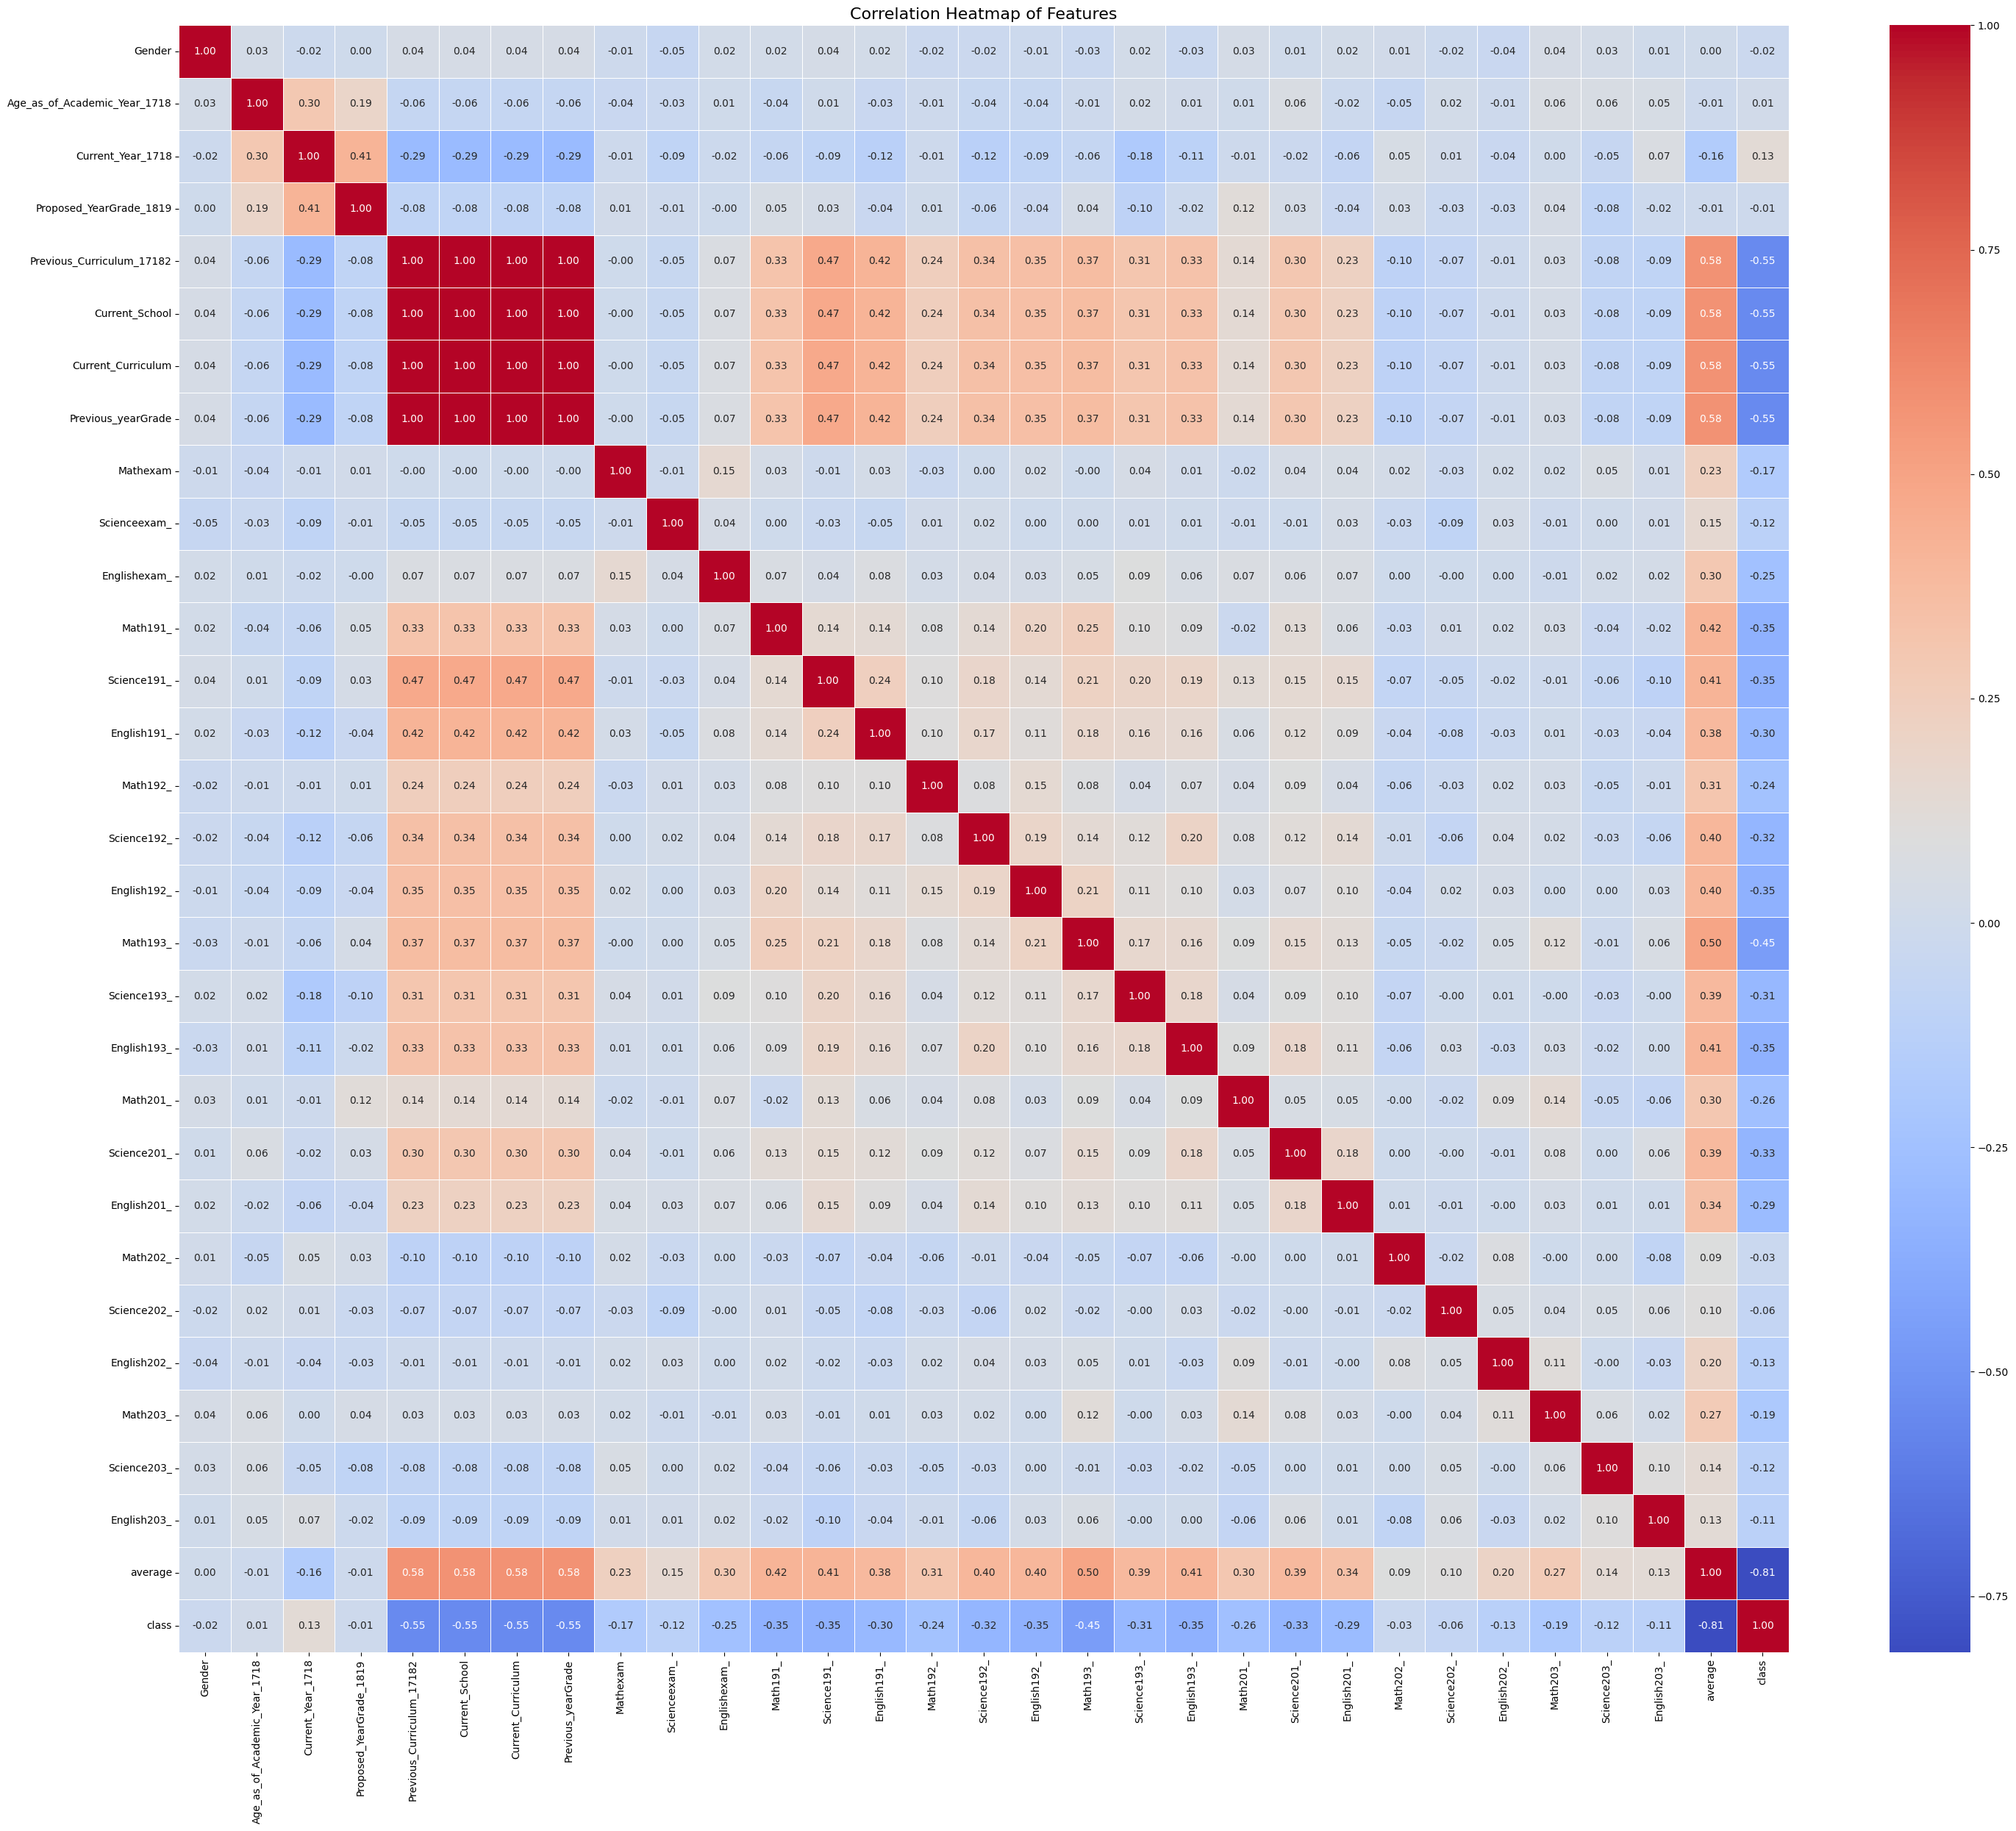

In [ ]:
# %%

# Step 4: Feature Engineering and Class Assignment
# 4.1 Load the preprocessed dataset
df = pd.read_excel(output_file_path, sheet_name='Data')

# Calculate the average score for the relevant subjects
columns_to_avg = ['Mathexam', 'Scienceexam_', 'Englishexam_', 'Math191_', 'Science191_', 'English191_',
                  'Math192_', 'Science192_', 'English192_', 'Math193_', 'Science193_', 'English193_',
                  'Math201_', 'Science201_', 'English201_', 'Math202_', 'Science202_', 'English202_',
                  'Math203_', 'Science203_', 'English203_']
df['average'] = df[columns_to_avg].mean(axis=1)

# 4.2 Assign class based on the average score
def assign_class(row):
    if row['average'] >= 79.9999:
        return 0  # Above 79.9999
    else:
        return 1  # Below 80

df['class'] = df.apply(assign_class, axis=1)
# 4.3 Save the dataset with the average and class columns to CSV
df.to_csv('The_Student_Dataset_Final.csv', index=False)

print("Dataset saved to final_dataset_file.csv")

# 4.4 Define input features (X) and target (y)
X = df.drop(columns=['class', 'average'])
y = df['class']

# Step 4.5: Plot the Correlation Heatmap to see feature dependencies
import seaborn as sns
import matplotlib.pyplot as plt

# 4.5.1 Calculate the correlation matrix
correlation_matrix = df.corr()

# 4.5.2 Plot the heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# %%

# Step 5: Check Imbalance in Features
feature_imbalance = {col: df[col].value_counts(normalize=True) for col in X.columns}

# Create a DataFrame to show imbalance in tabular form
imbalance_df = pd.DataFrame(feature_imbalance)
print("Feature Imbalance (Tabular View):")

# Step 5.1: Check Imbalance in Features
feature_imbalance = {col: df[col].value_counts(normalize=True) for col in X.columns}

# Create a DataFrame to show imbalance in tabular form
imbalance_df = pd.DataFrame(feature_imbalance)

# Save the imbalance DataFrame to an Excel file
imbalance_output_file_path = 'The_Student_Dataset_Feature_Imbalance_Results.xlsx'
imbalance_df.to_excel(imbalance_output_file_path, index=True)

print(f"Feature imbalance results saved to: {imbalance_output_file_path}")

Feature Imbalance (Tabular View):
Feature imbalance results saved to: The_Student_Dataset_Feature_Imbalance_Results.xlsx


In [ ]:
# %%

# Step 6: Model Definition and K-Fold Cross-Validation
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Tune LightGBM
lgbm_params = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.05, 0.1]
}
lgbm = LGBMClassifier(random_state=42)
grid_lgbm = GridSearchCV(lgbm, lgbm_params, cv=3, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X, y)
best_lgbm = grid_lgbm.best_estimator_
print("Best LightGBM Parameters:", grid_lgbm.best_params_)

# Tune XGBoost
xgb_params = {
    'n_estimators': [100, 150],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.05, 0.1]
}
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
# grid_xgb = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
# grid_xgb.fit(X, y)
# best_xgb = grid_xgb.best_estimator_
# print("Best XGBoost Parameters:", grid_xgb.best_params_)
print("Best XGBoost Parameters:", xgb_model)

# Tune MLP (for use in VotingClassifier)
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,)],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp = MLPClassifier(max_iter=1000, random_state=42)
grid_mlp = GridSearchCV(mlp, mlp_params, cv=3, scoring='accuracy', n_jobs=-1)
grid_mlp.fit(X, y)
best_mlp = grid_mlp.best_estimator_
print("Best MLP Parameters:", grid_mlp.best_params_)

# Define tuned models
models = {
    'LightGBM': best_lgbm,
    'XGBoost': xgb_model,
    'Voting Classifier': VotingClassifier(estimators=[
        ('log_reg', LogisticRegression(random_state=42, solver='liblinear')),
        ('ann', best_mlp),
        ('svm', SVC(kernel='linear', probability=True, random_state=42)),
        ('lightgbm', best_lgbm)
    ], voting='soft')
}

# Initialize result dictionary and confusion matrix storage
results = {model_name: {'Accuracy': [], 'F1-Score': [], 'Precision': [], 'Recall': [], 'ROC AUC': []} for model_name in models}
best_confusion_matrices = {}  # Initialize dictionary for confusion matrices
roc_curves = {}

# 6.2 Stratified K-Fold cross-validation setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6.3 Loop through each model and perform K-Fold Cross-Validation
for model_name, model in models.items():
    best_accuracy = -1  # To track the best accuracy of each model
    best_cm = None  # To store the confusion matrix of the best fold
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    for fold_num, (train_idx, test_idx) in enumerate(kfold.split(X, y), 1):
        # 6.3.1 Split data based on the current fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # 6.3.2 Train the model
        model.fit(X_train, y_train)
        
        # 6.3.3 Make predictions
        y_pred = model.predict(X_test)
        
        # 6.3.4 Check if the model has the 'predict_proba' method (for ROC curve)
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC curve
        else:
            y_prob = None  # Set to None if the model doesn't support probabilities
        
        # 6.3.5 Calculate the evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        
        # 6.3.6 Store the metrics for each fold
        results[model_name]['Accuracy'].append(accuracy)
        results[model_name]['F1-Score'].append(f1)
        results[model_name]['Precision'].append(precision)
        results[model_name]['Recall'].append(recall)
        if roc_auc is not None:
            results[model_name]['ROC AUC'].append(roc_auc)
        
        # 6.3.7 If this fold has the best accuracy, store the confusion matrix
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_cm = confusion_matrix(y_test, y_pred)
        
        # 6.3.8 Compute ROC curve if available
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
    
    # 6.4 Store the confusion matrix for the best fold of each model
    best_confusion_matrices[model_name] = best_cm
    
    # 6.5 Calculate mean ROC curve
    if tprs:
        mean_tpr = np.mean(tprs, axis=0)
        roc_curves[model_name] = (mean_fpr, mean_tpr)

[LightGBM] [Info] Number of positive: 655, number of negative: 742
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1913
[LightGBM] [Info] Number of data points in the train set: 1397, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468862 -> initscore=-0.124714
[LightGBM] [Info] Start training from score -0.124714
Best LightGBM Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Best XGBoost Parameters: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:55:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:55:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:55:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder"

[LightGBM] [Info] Number of positive: 524, number of negative: 593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 1117, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469114 -> initscore=-0.123703
[LightGBM] [Info] Start training from score -0.123703
[LightGBM] [Info] Number of positive: 524, number of negative: 593
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 1117, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.469114 -> initscore=-0.123703
[LightGBM] [Info] Start training from score -0.123703
[LightGBM] [Info] Numb

In [ ]:
# %%

# Step 6.5 
import joblib

# Save each model in the models dictionary
for model_name, model in models.items():
    # Specify the file path where the model will be saved
    # model_filename = f'{model_name}_model.pkl'
    model_filename = f'App/{model_name}_model.pkl'
    
    # Save the model using joblib
    joblib.dump(model, model_filename)
    print(f"Model {model_name} saved to {model_filename}")

Model LightGBM saved to App/LightGBM_model.pkl
Model XGBoost saved to App/XGBoost_model.pkl
Model Voting Classifier saved to App/Voting Classifier_model.pkl


In [ ]:
# %%

# Step 7: Display results in tabular form
import pandas as pd

# 7.1 Compute average values for each model across all folds
average_results = {
    model_name: {
        'Accuracy': np.mean(results[model_name]['Accuracy']),
        'F1-Score': np.mean(results[model_name]['F1-Score']),
        'Precision': np.mean(results[model_name]['Precision']),
        'Recall': np.mean(results[model_name]['Recall']),
        'ROC AUC': np.mean(results[model_name]['ROC AUC']) if len(results[model_name]['ROC AUC']) > 0 else None
    }
    for model_name in models
}

# 7.2 Convert average results into a DataFrame
metrics_df = pd.DataFrame(average_results).T  # Transpose the results to have models as rows
metrics_df = metrics_df.round(3)  # Round to 3 decimal places for better readability

# 7.3 Show the results in tabular format
print("\nEvaluation Metrics for All Models (Average across all folds):")
print(metrics_df)

# 7.4 Optionally, display the table in a more formatted manner

print("\nFormatted Table:")
# print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))


Evaluation Metrics for All Models (Average across all folds):
                   Accuracy  F1-Score  Precision  Recall  ROC AUC
LightGBM              0.899     0.890      0.912   0.869    0.965
XGBoost               0.893     0.883      0.906   0.861    0.966
Voting Classifier     0.929     0.923      0.941   0.907    0.985

Formatted Table:


Class distribution in training data:
class
0    594
1    524
Name: count, dtype: int64
Class distribution in test data:
class
0    148
1    131
Name: count, dtype: int64


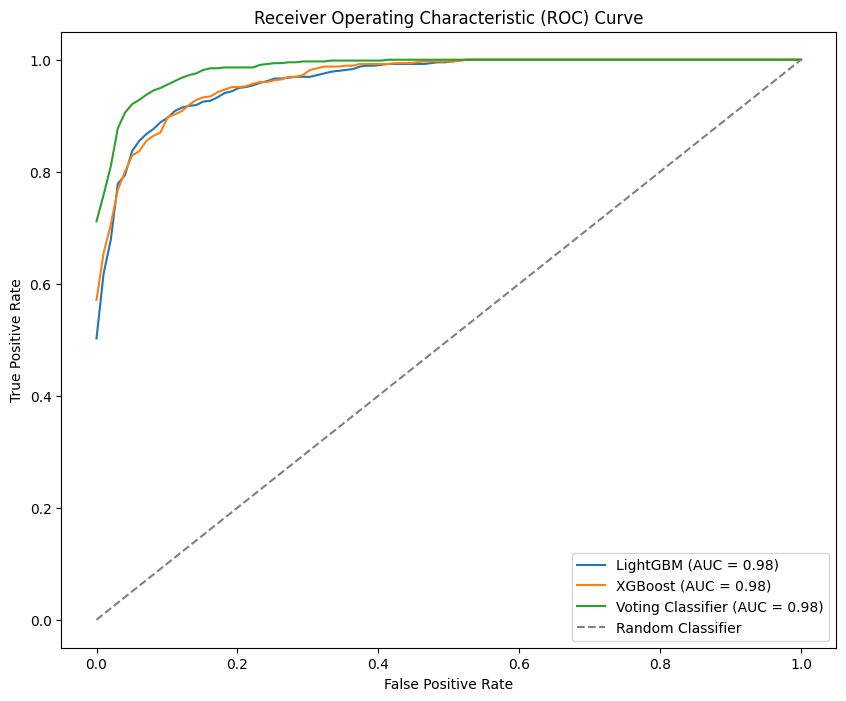

In [ ]:
# %%

# Step 8: Plot ROC curves for each model
print("Class distribution in training data:")
print(y_train.value_counts())

print("Class distribution in test data:")
print(y_test.value_counts())

plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

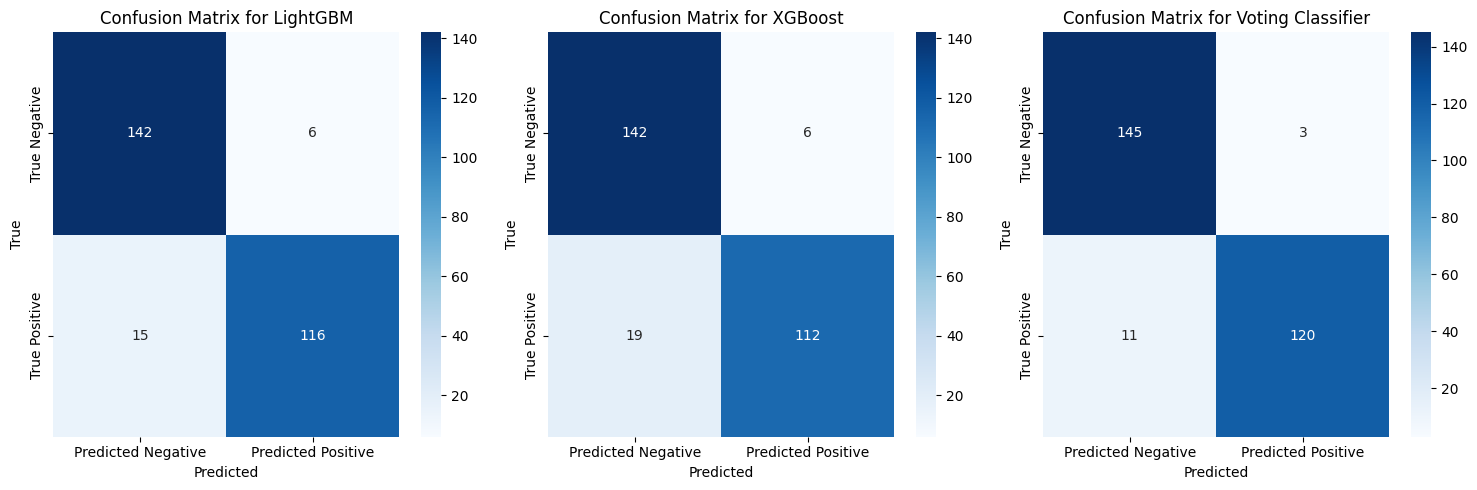


Evaluation Metrics for All Models:
                                                    LightGBM  \
Accuracy   [0.8928571428571429, 0.8821428571428571, 0.906...   
F1-Score   [0.8818897637795275, 0.8735632183908046, 0.898...   
Precision  [0.9105691056910569, 0.8769230769230769, 0.92,...   
Recall     [0.8549618320610687, 0.8702290076335878, 0.877...   
ROC AUC    [0.9757672011885855, 0.9531225984937752, 0.967...   

                                                     XGBoost  \
Accuracy   [0.8964285714285715, 0.875, 0.910394265232975,...   
F1-Score   [0.8871595330739299, 0.8679245283018868, 0.899...   
Precision  [0.9047619047619048, 0.8582089552238806, 0.949...   
Recall     [0.8702290076335878, 0.8778625954198473, 0.854...   
ROC AUC    [0.9730518981505201, 0.9554792766022849, 0.972...   

                                           Voting Classifier  
Accuracy   [0.9428571428571428, 0.9107142857142857, 0.949...  
F1-Score   [0.937984496124031, 0.9063670411985019, 0.9448...  
Preci

In [ ]:
# %%

# Step 9: Confusion Matrices for All Models
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(1,3, figsize=(15, 5))

# 9.1 Flatten the axes array to make indexing easier
axes = axes.flatten()
# 9.2 Loop through all the models and plot each confusion matrix
for i, (model_name, cm) in enumerate(best_confusion_matrices.items()):
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
    ax.set_title(f"Confusion Matrix for {model_name}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# 9.3Adjust layout to prevent overlapping labels
plt.tight_layout()

# 9.4 Show the combined plot
plt.show()

# 9.5 Convert results dictionary into DataFrame (for display)
metrics_df = pd.DataFrame(results)

# 9.6 Show the results in tabular format
print("\nEvaluation Metrics for All Models:")
print(metrics_df)

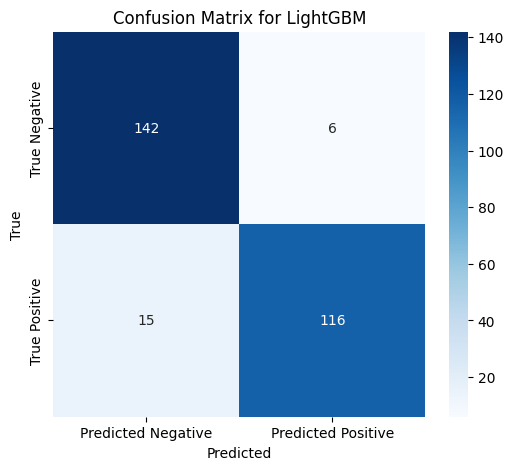

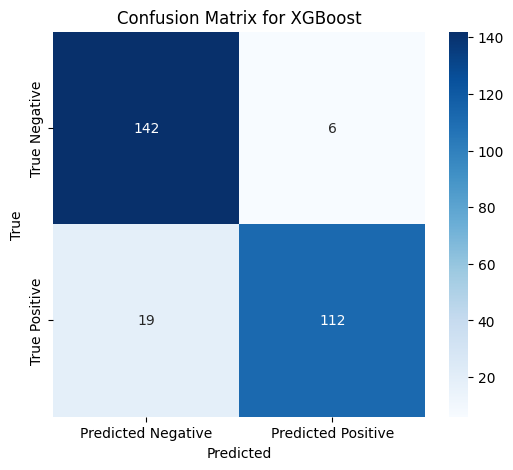

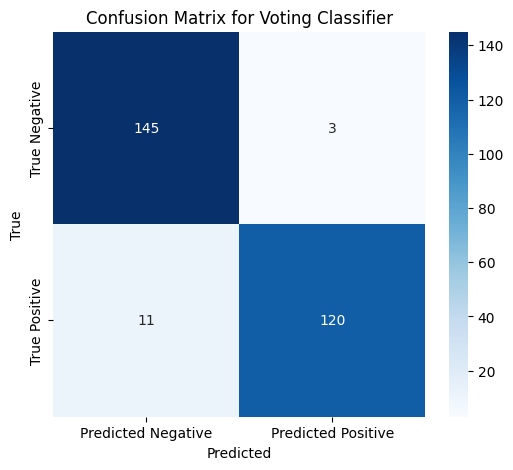

In [ ]:
# %%

# Step 10: Plot confusion matrices for each model separately
import seaborn as sns
import matplotlib.pyplot as plt

# 10.1 Loop through all the models and plot each confusion matrix separately
for model_name, cm in best_confusion_matrices.items():
    plt.figure(figsize=(6, 5))  # Adjust the size of the figure for each confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()  # Display the confusion matrix for the current model

In [ ]:
# %%

# Step 11: Calculate the correlation matrix for all features and target variable 'class'
import os
import pandas as pd

# 11.1 Calculate the correlation matrix for all features and target variable 'class'
correlation_matrix = df.corr()

# 11.2 Get correlation with the target variable 'class'
target_correlation = correlation_matrix['class'].sort_values(ascending=False)

# 11.3 Convert the correlation to a DataFrame for better presentation
correlation_table = pd.DataFrame(target_correlation).reset_index()

# Rename columns for clarity
correlation_table.columns = ['Feature', 'Correlation_with_class']

# Add a column with explanations based on the correlation value
def get_correlation_explanation(correlation_value):
    if correlation_value == 1:
        return "Perfect positive correlation: As one increases, the other increases in exact proportion."
    elif correlation_value == -1:
        return "Perfect negative correlation: As one increases, the other decreases in exact proportion."
    elif correlation_value > 0.7:
        return "Strong positive correlation: A strong relationship where both increase or decrease together."
    elif correlation_value > 0.3:
        return "Moderate positive correlation: A moderate relationship where both tend to increase together."
    elif correlation_value < -0.7:
        return "Strong negative correlation: A strong relationship where one increases while the other decreases."
    elif correlation_value < -0.3:
        return "Moderate negative correlation: A moderate relationship where one increases while the other decreases."
    else:
        return "Weak or no correlation: Little to no linear relationship between the feature and the target."

# Apply the explanation function to the correlation values
correlation_table['Explanation'] = correlation_table['Correlation_with_class'].apply(get_correlation_explanation)

# Directory path to save the CSV file
directory_path = './'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Output file path
output_file_path = os.path.join(directory_path, 'The_Student_Dataset_Correlation_with_class.csv')

# Save the results to a CSV file
correlation_table.to_csv(output_file_path, index=False)

print(f"Correlation results with explanations saved to: {output_file_path}")

import pandas as pd

# Extract FP, FN, TP, TN from confusion matrices
confusion_values = []

for model_name, cm in best_confusion_matrices.items():
    # The confusion matrix format is:
    # [[TN, FP],
    #  [FN, TP]]
    
    TN, FP, FN, TP = cm.ravel()  # Flatten the confusion matrix to get the values
    confusion_values.append({
        "Model Name": model_name,
        "FP": FP,
        "FN": FN,
        "TP": TP,
        "TN": TN
    })

# Convert the list of dictionaries into a DataFrame
confusion_df = pd.DataFrame(confusion_values)

# Save the confusion matrix values to a CSV file
output_file_path = 'The_Student_Dataset_Model_Confusion_Matrix_Values.csv'
confusion_df.to_csv(output_file_path, index=False)

print(f"Confusion matrix values saved to: {output_file_path}")

Correlation results with explanations saved to: ./The_Student_Dataset_Correlation_with_class.csv
Confusion matrix values saved to: The_Student_Dataset_Model_Confusion_Matrix_Values.csv


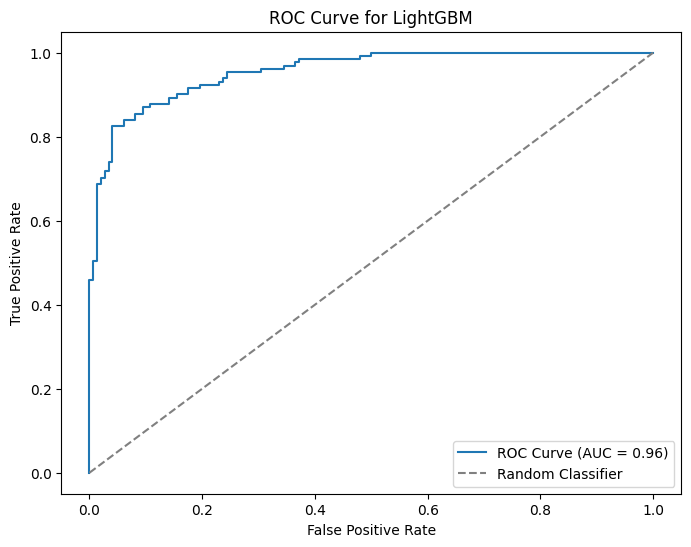

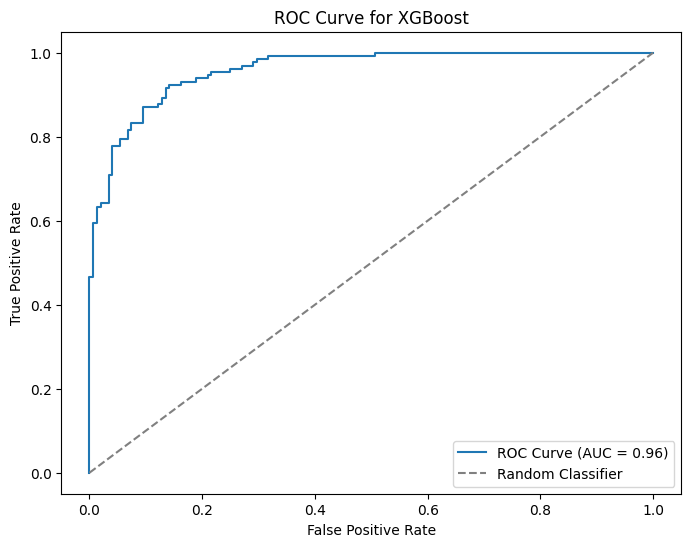

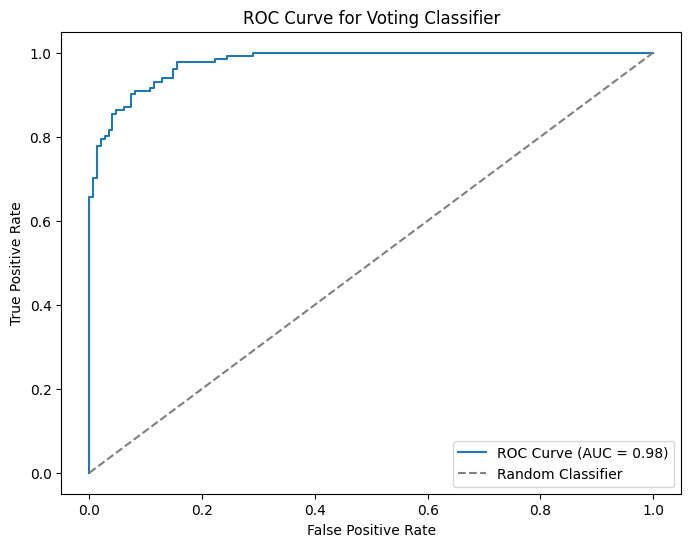

In [ ]:
# %%

# Step 12: Plot ROC curves for each model separately
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Loop through each model and plot its ROC curve
for model_name, model in models.items():
    # Check if the model has the 'predict_proba' method to compute the probabilities
    if hasattr(model, 'predict_proba'):
        # Get the predicted probabilities for the positive class
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        
        # Calculate ROC AUC score
        auc_score = roc_auc_score(y_test, y_prob)
        
        # Plot the ROC curve for each model
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()  # Display the ROC curve for the current model
    else:
        print(f"Model {model_name} does not support ROC curve (no 'predict_proba' method).")

In [ ]:
# %%

# Step 13: Generate Predictions & Save Results to CSV
# Assuming the model is trained and X_test is available

# Add predictions to the dataset
data = X_test.copy()  # Copy the test set to preserve it
data['Actual_Value'] = (y_test) # The actual data value
# data['predict_value'] = model.predict(X_test)  # Assuming the model is already defined and trained
data['Predict_Value LightGBM'] = models['LightGBM'].predict(X_test)
data['Predict_Value Voting_Classifier'] = models['Voting Classifier'].predict(X_test)
data['Predict_Value XGBoost'] = models['XGBoost'].predict(X_test)

# Save the dataframe to CSV
output_path = 'The_Student_Dataset_The_Predicted_Output.csv'
data.to_csv(output_path, index=False)
print(f"Predictions saved to: {output_path}")

Predictions saved to: The_Student_Dataset_The_Predicted_Output.csv


C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\s


Chosen Instance 112:
Actual Value: 1
LightGBM Predicted Value: 1 (Correct)
Voting Classifier Predicted Value: 1 (Correct)
XGBoost Predicted Value: 1 (Correct)


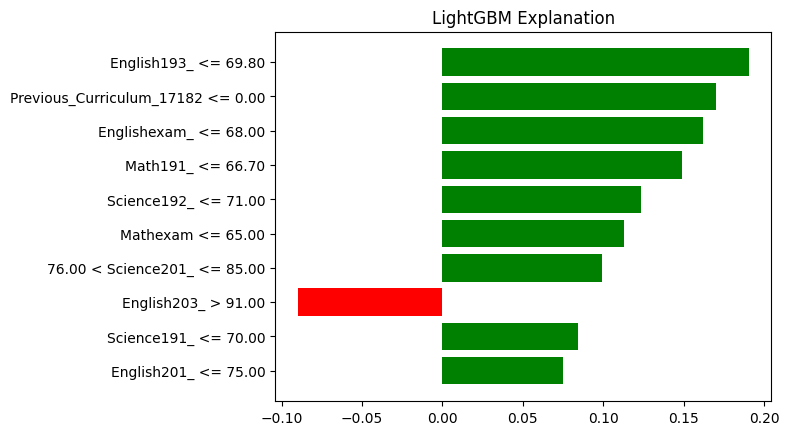

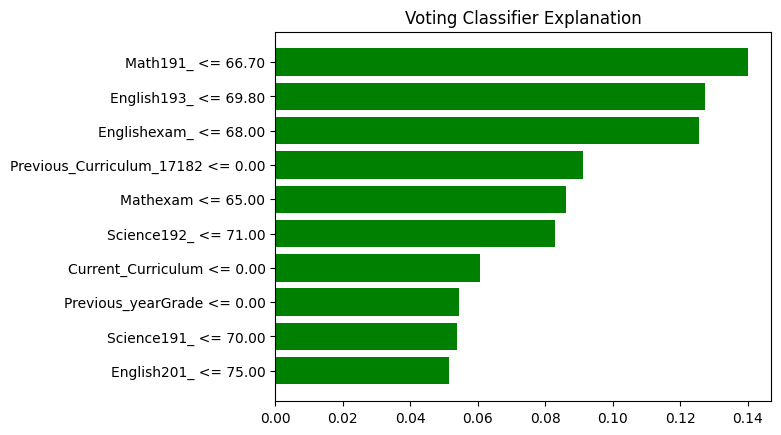

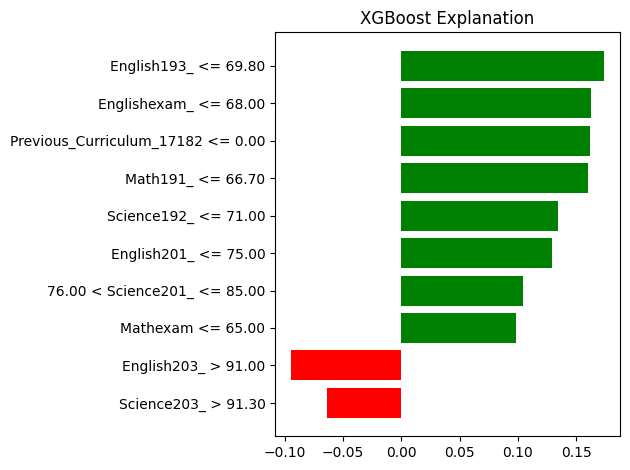

In [ ]:
# %%

# Step 14: LIME for instance with visualization.
import matplotlib.pyplot as plt
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd

# LIME explainer setup for all models
# LIME explainer setup for all models
lightgbm_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    class_names=['0', '1'],
    mode='classification'
)

xgb_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    class_names=['0', '1'],
    mode='classification'
)

vc_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    class_names=['0', '1'],
    mode='classification'
)

# User input for which instance to explain (Use the index of the test set)
index_to_check = int(input("Enter the index of the instance to explain: ")) - 2  # User input for test instance

# Ensure the index is within the range of the test data
if 0 <= index_to_check < len(X_test):
    instance = X_test.iloc[index_to_check]
    actual_value = y_test.iloc[index_to_check]
    
    # Get predictions for the instance using all models
    predicted_value_lightgbm = models['LightGBM'].predict(instance.values.reshape(1, -1))[0]
    predicted_value_vc = models['Voting Classifier'].predict(instance.values.reshape(1, -1))[0]
    predicted_value_XGBoost = models['XGBoost'].predict(instance.values.reshape(1, -1))[0]
    
    # Check if the predictions are correct or not
    prediction_correct_lightgbm = "Correct" if actual_value == predicted_value_lightgbm else "Incorrect"
    prediction_correct_vc = "Correct" if actual_value == predicted_value_vc else "Incorrect"
    prediction_correct_XGBoost = "Correct" if actual_value == predicted_value_XGBoost else "Incorrect"
    
    # Display the chosen instance details
    print(f"\nChosen Instance {index_to_check + 1}:")
    print(f"Actual Value: {actual_value}")
    print(f"LightGBM Predicted Value: {predicted_value_lightgbm} ({prediction_correct_lightgbm})")
    print(f"Voting Classifier Predicted Value: {predicted_value_vc} ({prediction_correct_vc})")
    print(f"XGBoost Predicted Value: {predicted_value_XGBoost} ({prediction_correct_XGBoost})")
    
    # Create subplots for visual comparison
    # fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Get LIME explanations and display them on the subplots
    explanations = {
        'LightGBM': lightgbm_explainer.explain_instance(instance.values, models['LightGBM'].predict_proba, num_features=10),
        'Voting Classifier': vc_explainer.explain_instance(instance.values, models['Voting Classifier'].predict_proba, num_features=10),
        'XGBoost': xgb_explainer.explain_instance(instance.values, models['XGBoost'].predict_proba, num_features=10)
    }
    
    # Iterate over explanations to plot them
    for ax, (model_name, explanation) in zip(axes.flat, explanations.items()):
        explanation.as_pyplot_figure(label=1).axes[0].set_title(f'{model_name} Explanation')
    
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

else:
    print("Invalid index. Please enter a valid index from the test data.")

In [ ]:
# %% 

# Step 15: Display and Save Numerical Feature Importance for Each Model using LIME

# Function to extract and return feature importances as a list of dictionaries
def get_lime_feature_importances(explanations, model_name):
    feature_importances = explanations.as_list()
    # Sort features by importance (absolute value of weight)
    sorted_feature_importances = sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True)
    
    # Prepare the data for saving to CSV
    feature_data = [{'Model': model_name, 'Feature': feature, 'Importance': importance} for feature, importance in sorted_feature_importances]
    
    return feature_data

# Create a list to store all feature importances
all_feature_importances = []

# Ensure the index is valid
if 0 <= index_to_check < len(X_test):
    instance = X_test.iloc[index_to_check]
    actual_value = y_test.iloc[index_to_check]
    
    # Get LIME explanations for each model
    explanations = {
        'LightGBM': lightgbm_explainer.explain_instance(instance.values, models['LightGBM'].predict_proba, num_features=10),
        'Voting Classifier': vc_explainer.explain_instance(instance.values, models['Voting Classifier'].predict_proba, num_features=10),
        'XGBoost': xgb_explainer.explain_instance(instance.values, models['XGBoost'].predict_proba, num_features=10)
    }
    
    # Collect feature importances for each model
    for model_name, explanation in explanations.items():
        feature_importances = get_lime_feature_importances(explanation, model_name)
        all_feature_importances.extend(feature_importances)
    
    # Convert the list of dictionaries to a DataFrame
    feature_importance_df = pd.DataFrame(all_feature_importances)
    
    # Define the output path for the CSV file
    output_csv_path = 'The_Student_Dataset_Lime_Feature_Importances.csv'
    
    # Save the feature importances to CSV
    feature_importance_df.to_csv(output_csv_path, index=False)
    print(f"Feature importances saved to: {output_csv_path}")
else:
    print("Invalid index. Please enter a valid index from the test data.")

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\s

Feature importances saved to: The_Student_Dataset_Lime_Feature_Importances.csv


Generating SHAP values for LightGBM...
Generating SHAP values for XGBoost...
Global SHAP Summary Plot for LightGBM:


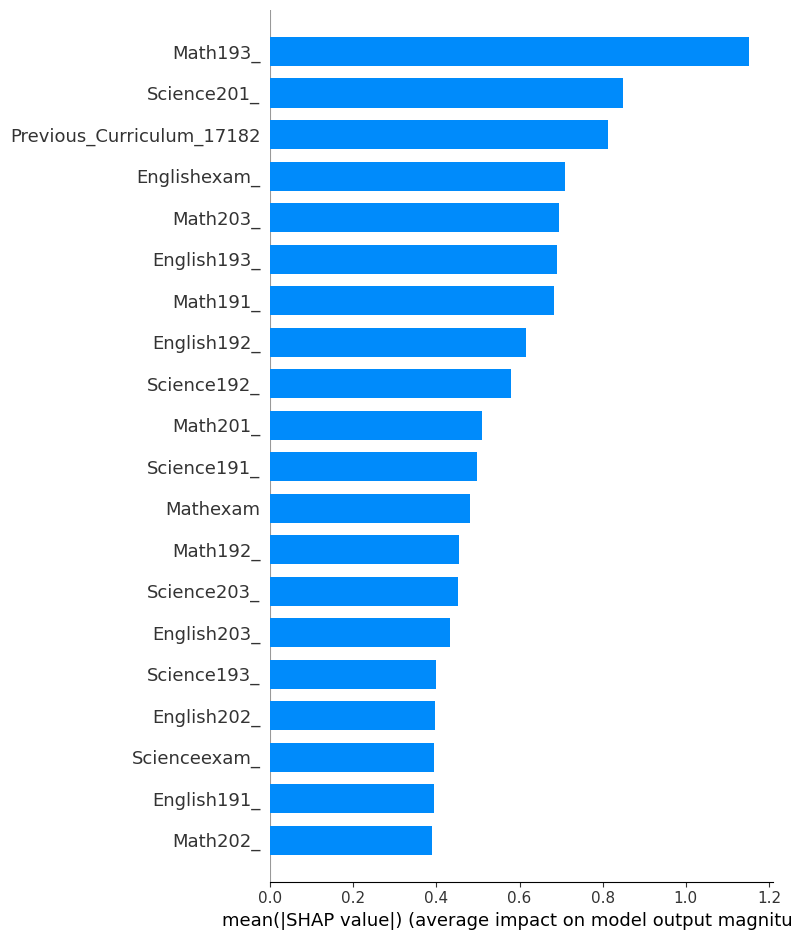

Global SHAP Summary Plot for XGBoost:


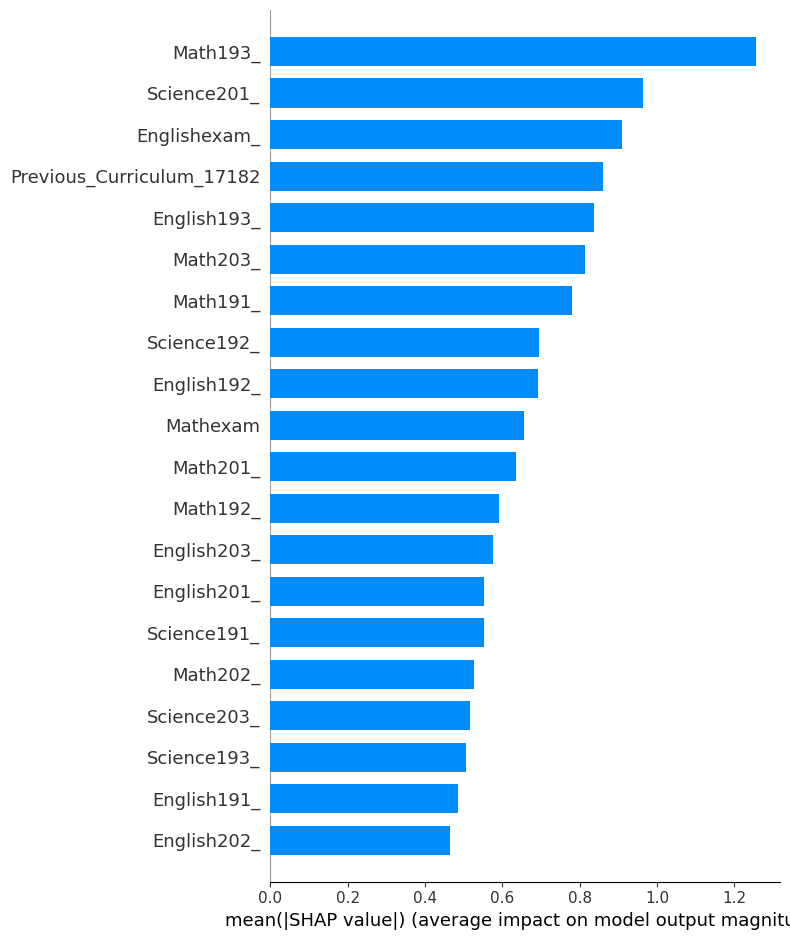


SHAP Local Explanation for Instance 112:

LightGBM:


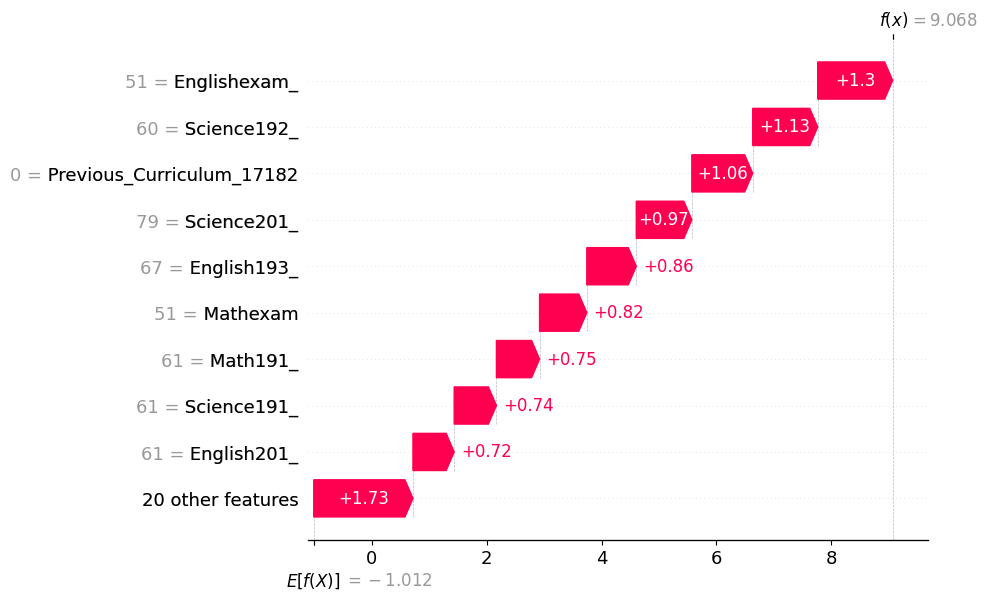


XGBoost:


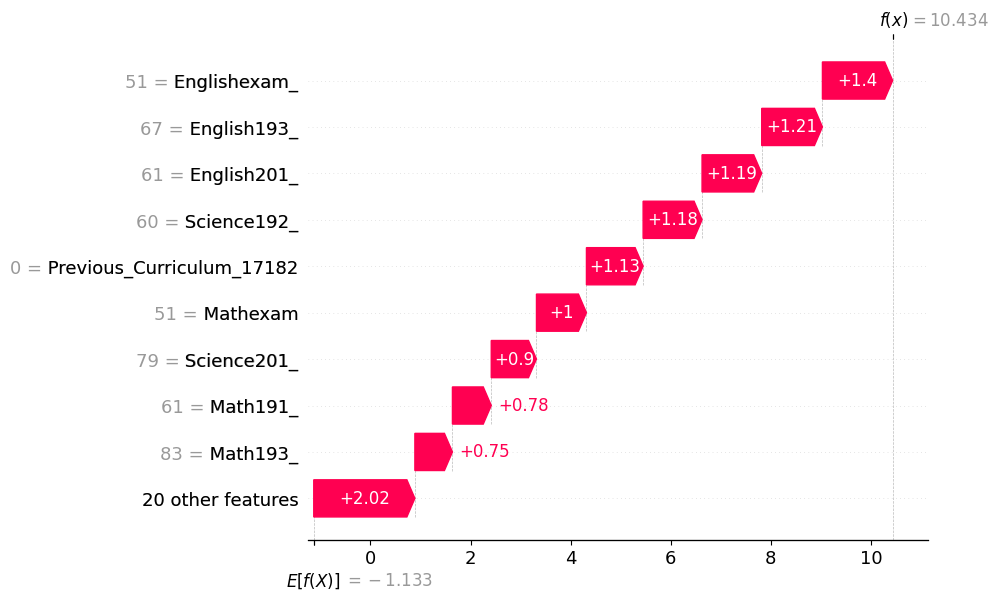

Global SHAP Summary (Dot Plot) for LightGBM:


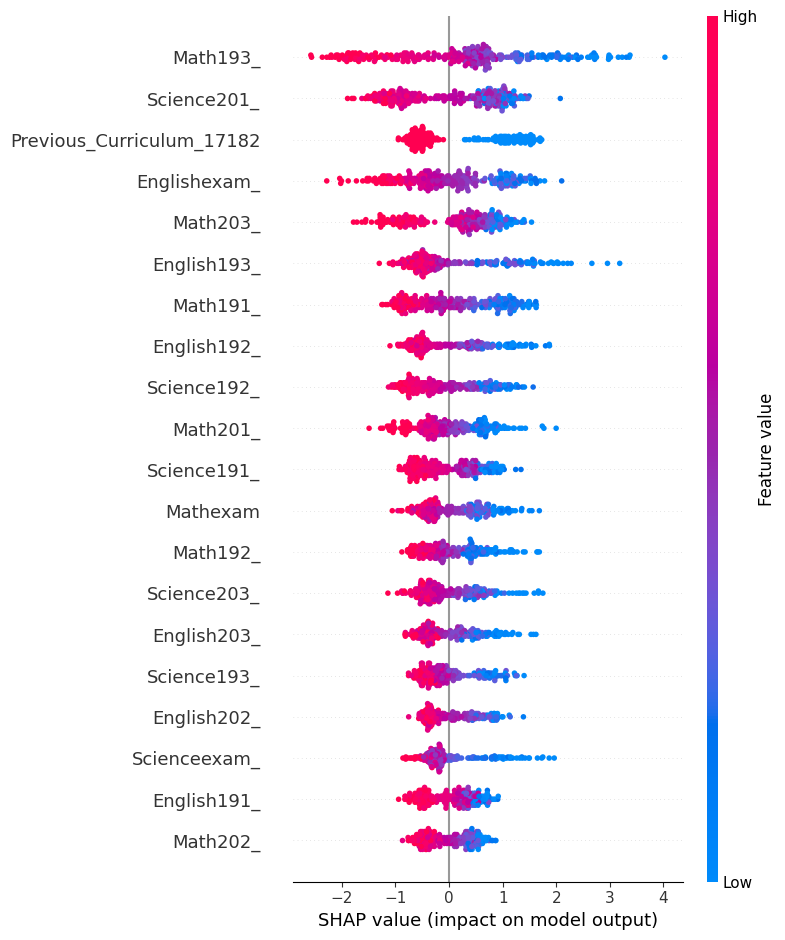

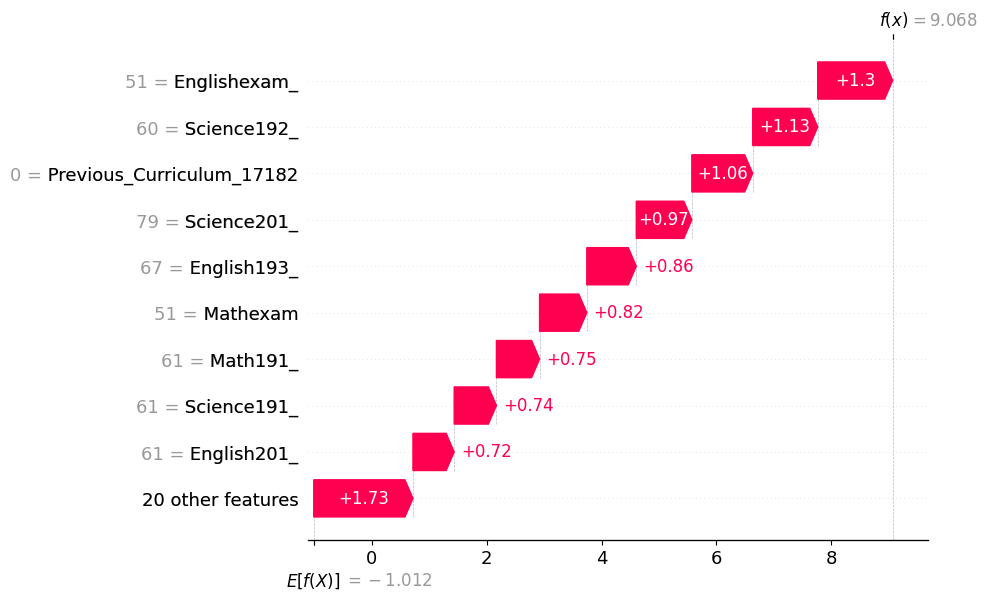

In [ ]:
# %% 

# Step 16: SHAP Global and Local Interpretability
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Enable JavaScript visualization in Jupyter (if used)
shap.initjs()

# SHAP for LightGBM
print("Generating SHAP values for LightGBM...")
explainer_lgbm = shap.Explainer(models['LightGBM'], X_train)
shap_values_lgbm = explainer_lgbm(X_test, check_additivity=False)

# SHAP for XGBoost
print("Generating SHAP values for XGBoost...")
explainer_xgb = shap.Explainer(models['XGBoost'], X_train)
shap_values_xgb = explainer_xgb(X_test, check_additivity=False)

# SHAP for Voting Classifier removed due to lack of reliable support

# Step 16.1: Global Feature Importance (summary plot)
print("Global SHAP Summary Plot for LightGBM:")
shap.summary_plot(shap_values_lgbm, X_test, plot_type='bar')

print("Global SHAP Summary Plot for XGBoost:")
shap.summary_plot(shap_values_xgb, X_test, plot_type='bar')

# Step 16.2: Local Explanation for a single instance

# Ensure index_to_check is defined and valid
if 0 <= index_to_check < len(X_test):
    print(f"\nSHAP Local Explanation for Instance {index_to_check + 1}:")

    print("\nLightGBM:")
    shap.plots.waterfall(shap_values_lgbm[index_to_check])

    print("\nXGBoost:")
    shap.plots.waterfall(shap_values_xgb[index_to_check])
else:
    print("Invalid index for SHAP local explanation.")

# Step 16.3: Additional visualizations
print("Global SHAP Summary (Dot Plot) for LightGBM:")
shap.summary_plot(shap_values_lgbm, X_test)

# Optional: Waterfall plot again for easy viewing
shap.plots.waterfall(shap_values_lgbm[index_to_check])
plt.show()

In [ ]:
# %% 

# Step 17: Global SHAP importances to CSV

# Extract mean absolute SHAP values
importance_lgbm = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_Importance_LGBM': np.abs(shap_values_lgbm.values).mean(axis=0)
})

importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'SHAP_Importance_XGBoost': np.abs(shap_values_xgb.values).mean(axis=0)
})

# Merge and export
importance_df = importance_lgbm.merge(importance_xgb, on='Feature')
output_file_Location = importance_df.to_csv('The_Student_Dataset_SHAP_Global_Features_Importance.csv', index=False)
print("Global SHAP importance saved to: ", output_file_Location)

Global SHAP importance saved to:  None


Native feature importances saved to: The_Student_Dataset_Native_Feature_Importance.csv


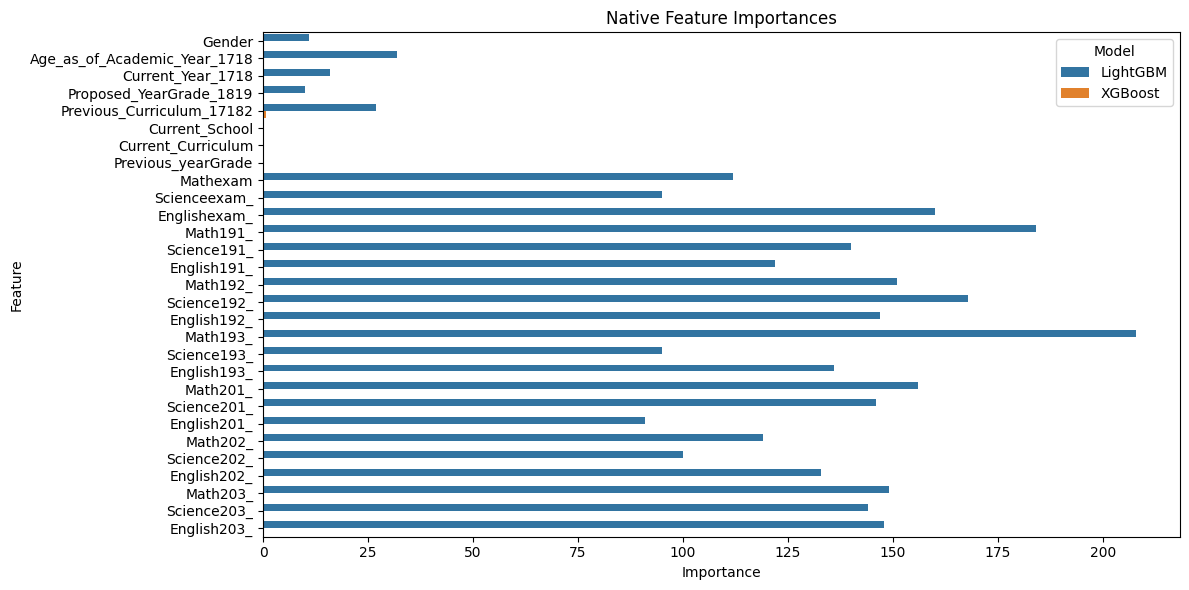

In [ ]:
# %%

# Next step 1: Native Feature Importance from LightGBM & XGBoost

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract native feature importances
lightgbm_fi = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models['LightGBM'].feature_importances_,
    'Model': 'LightGBM'
})

xgboost_fi = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models['XGBoost'].feature_importances_,
    'Model': 'XGBoost'
})

# Combine into one dataframe
native_fi_df = pd.concat([lightgbm_fi, xgboost_fi], ignore_index=True)

# Save to CSV
native_fi_path = 'The_Student_Dataset_Native_Feature_Importance.csv'
native_fi_df.to_csv(native_fi_path, index=False)
print(f"Native feature importances saved to: {native_fi_path}")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=native_fi_df, x='Importance', y='Feature', hue='Model')
plt.title('Native Feature Importances')
plt.tight_layout()
plt.savefig('The_Student_Dataset_Native_Feature_Importance.png')
plt.show()


Calculating permutation importance for LightGBM...
Saved to: The_Student_Dataset_Permutation_Importance_LightGBM.csv


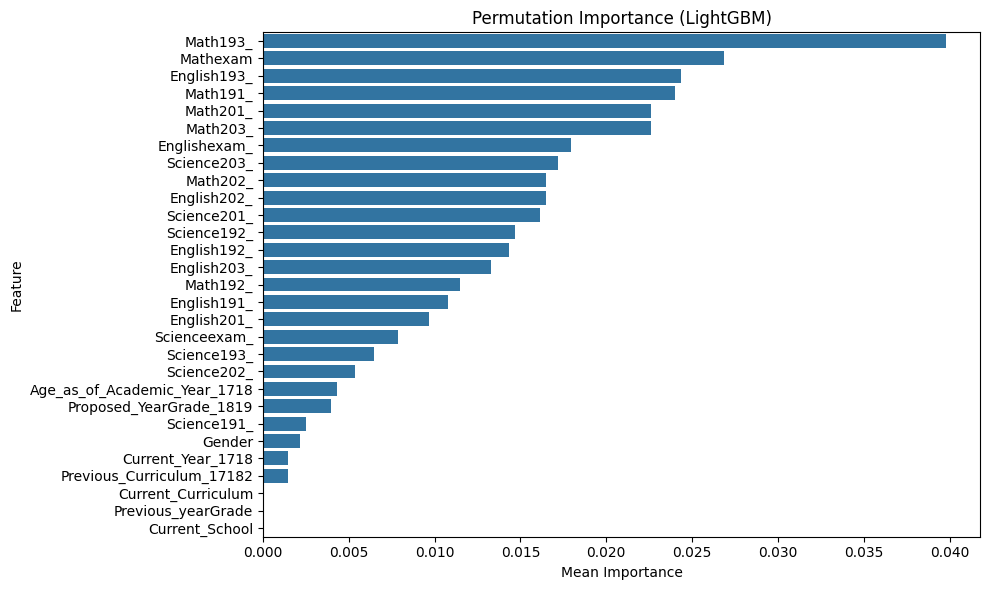


Calculating permutation importance for XGBoost...
Saved to: The_Student_Dataset_Permutation_Importance_XGBoost.csv


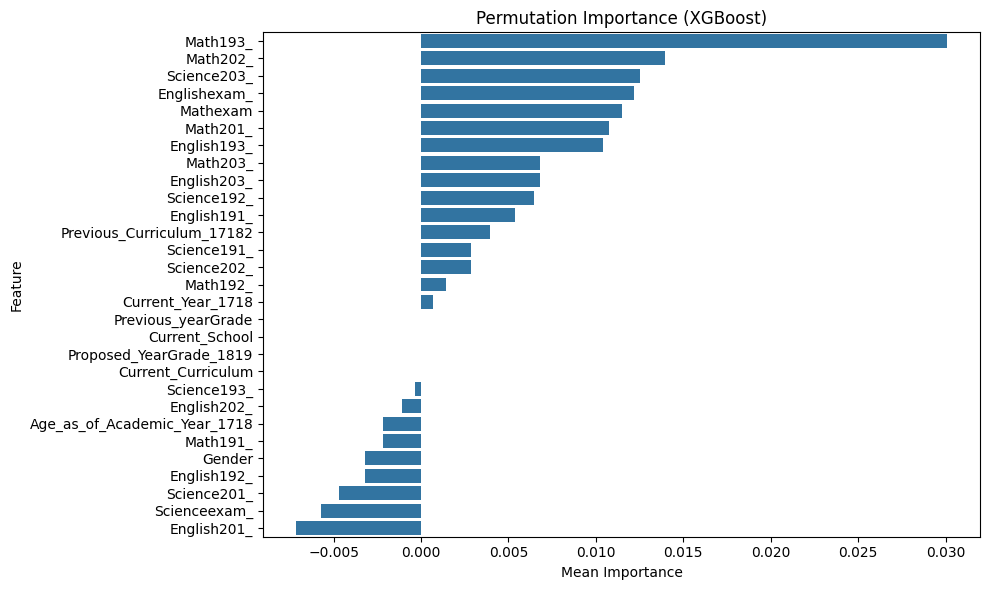

In [ ]:
# %%

# Step 2: Permutation Importance for LightGBM and XGBoost

from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

top_features_dict = {}  # To store top features for each model

for model_name in ['LightGBM', 'XGBoost']:
    print(f"\nCalculating permutation importance for {model_name}...")

    perm_result = permutation_importance(
        models[model_name],
        X_test,
        y_test,
        n_repeats=10,
        random_state=42
    )

    perm_df = pd.DataFrame({
        'Feature': X.columns,
        'Mean Importance': perm_result.importances_mean,
        'Std Dev': perm_result.importances_std
    }).sort_values(by='Mean Importance', ascending=False)

    # Save CSV
    csv_path = f'The_Student_Dataset_Permutation_Importance_{model_name}.csv'
    perm_df.to_csv(csv_path, index=False)
    print(f"Saved to: {csv_path}")

    # Save top 3 features for PDP
    top_features_dict[model_name] = perm_df['Feature'].head(3).tolist()

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=perm_df, x='Mean Importance', y='Feature')
    plt.title(f'Permutation Importance ({model_name})')
    plt.tight_layout()
    plt.savefig(f'The_Student_Dataset_Permutation_Importance_{model_name}.png')
    plt.show()


Generating PDPs for LightGBM...


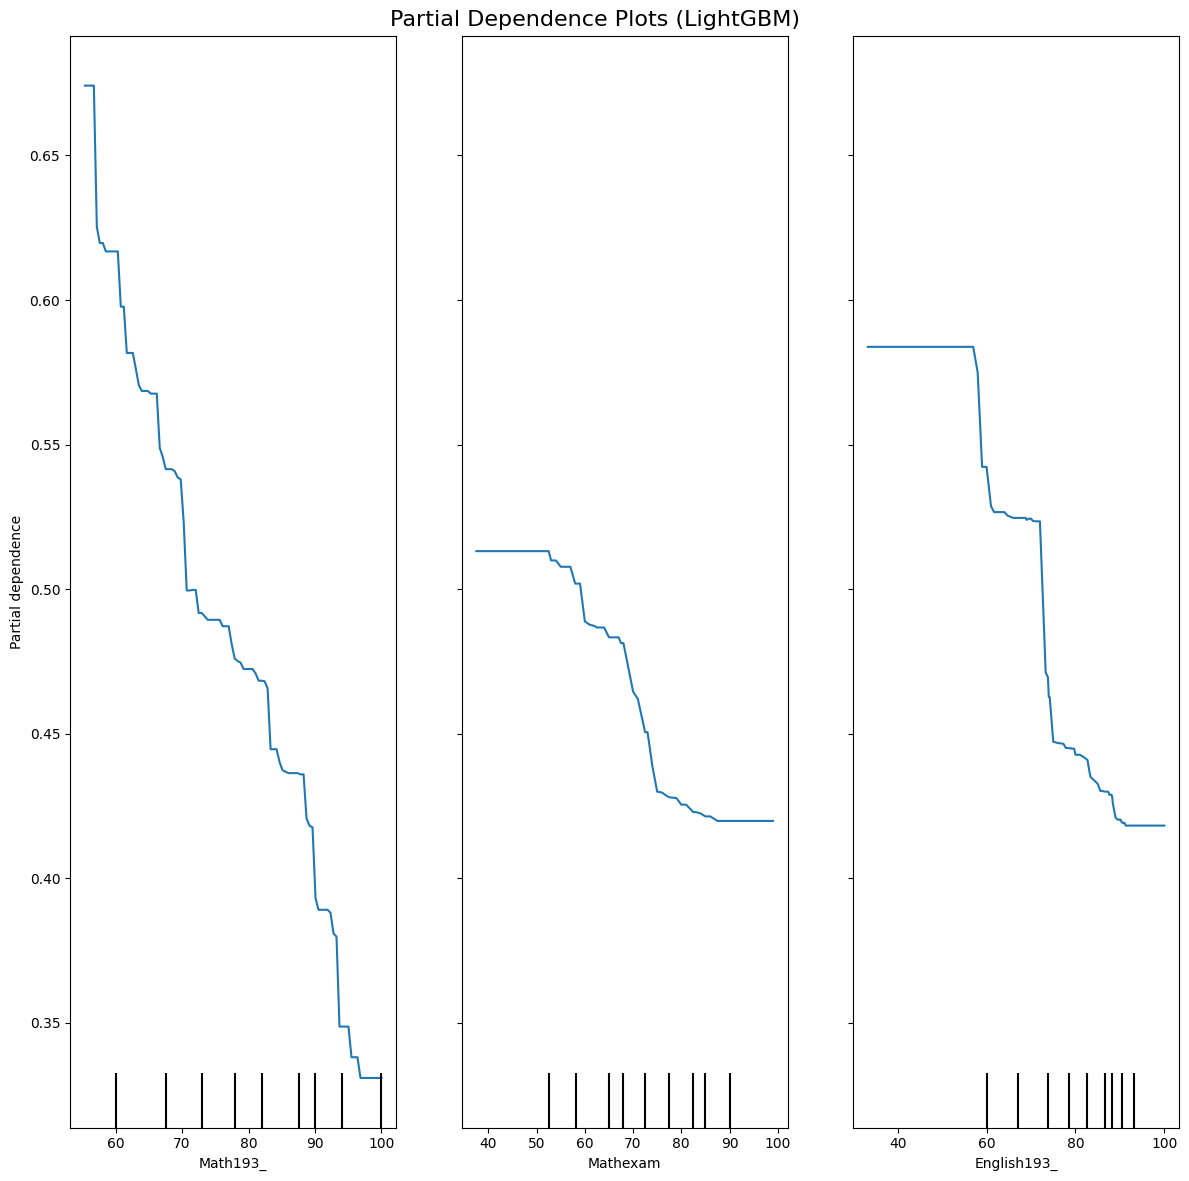


Generating PDPs for XGBoost...


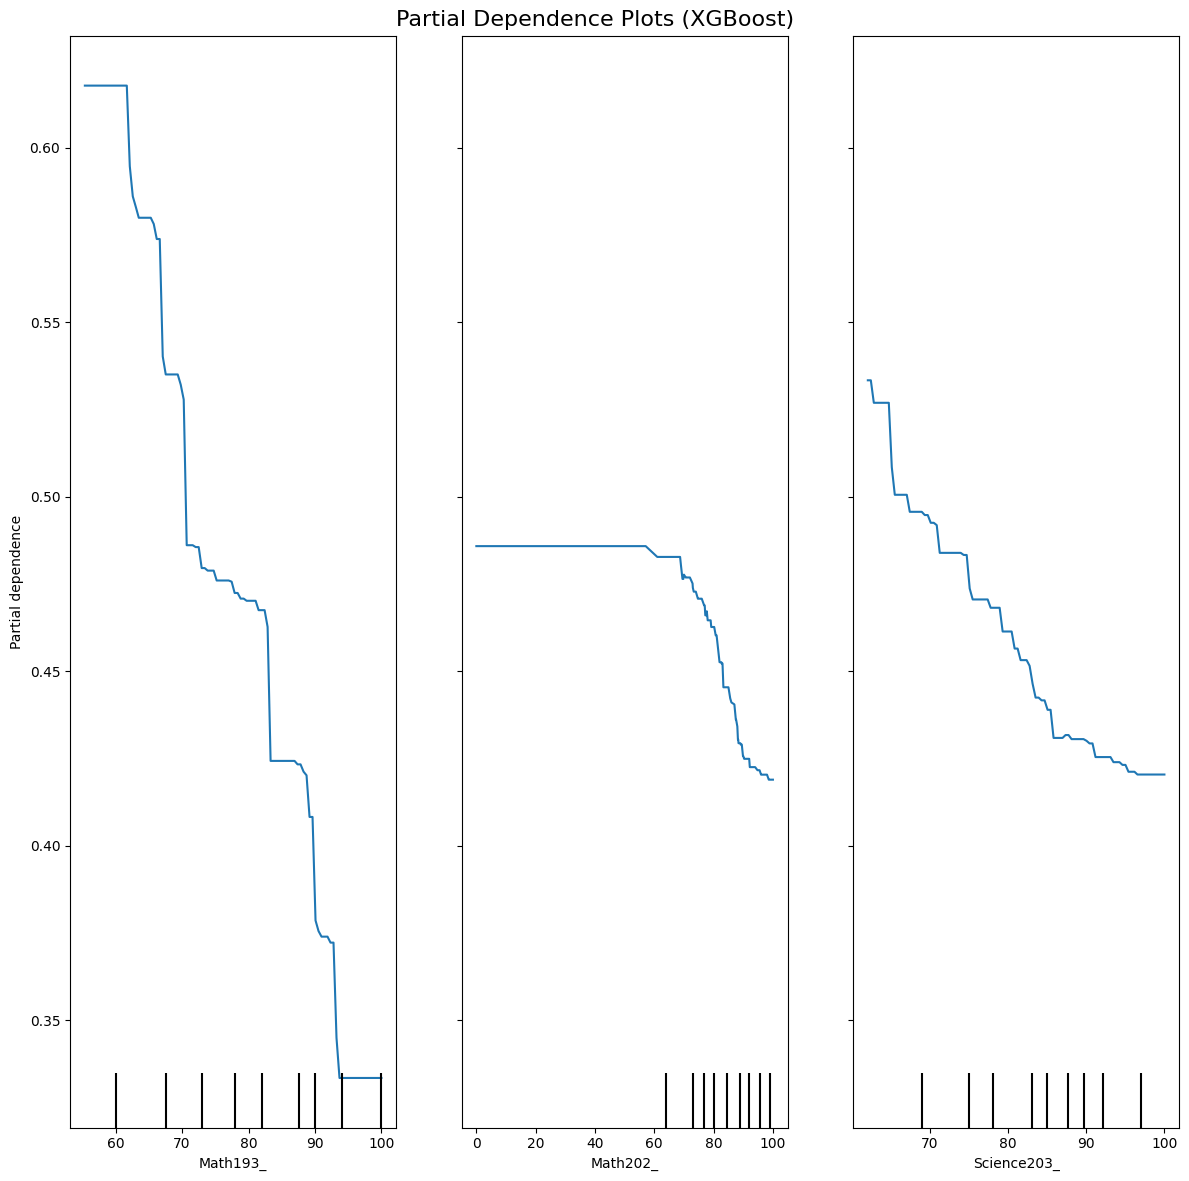

In [ ]:
# %%

# Step 3: Partial Dependence Plots (PDP) for LightGBM and XGBoost

from sklearn.inspection import PartialDependenceDisplay

for model_name in ['LightGBM', 'XGBoost']:
    print(f"\nGenerating PDPs for {model_name}...")

    top_features = top_features_dict[model_name]

    fig, ax = plt.subplots(figsize=(12, 4 * len(top_features)))
    PartialDependenceDisplay.from_estimator(
        models[model_name],
        X_test,
        features=top_features,
        ax=ax
    )

    plt.suptitle(f'Partial Dependence Plots ({model_name})', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'The_Student_Dataset_PDP_{model_name}.png')
    plt.show()

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


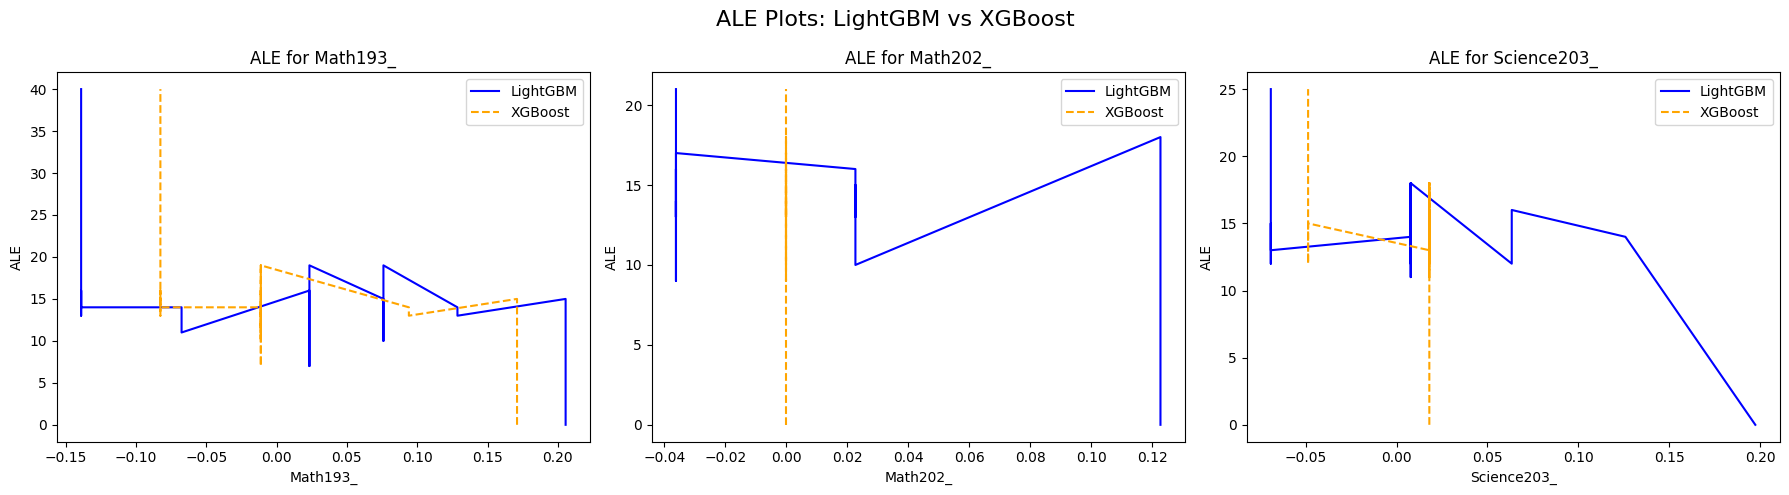

In [ ]:
# %%

# Next step 4: Accumulated Local Effects (ALE) Plot

# Compute ALE for LightGBM and top 3 features
from PyALE import ale
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

for i, feature in enumerate(top_features):
    # ALE for LightGBM
    ale_lgb = ale(X=X_test, model=models['LightGBM'], feature=[feature], include_CI=False, plot=False)

    # ALE for XGBoost
    ale_xgb = ale(X=X_test, model=models['XGBoost'], feature=[feature], include_CI=False, plot=False)

    # Plot both on the same axis
    axs[i].plot(ale_lgb['eff'], ale_lgb['size'], label='LightGBM', color='blue')
    axs[i].plot(ale_xgb['eff'], ale_xgb['size'], label='XGBoost', color='orange', linestyle='--')

    axs[i].set_title(f"ALE for {feature}")
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("ALE")
    axs[i].legend()

plt.suptitle("ALE Plots: LightGBM vs XGBoost", fontsize=16)
plt.tight_layout()
plt.savefig('The_Student_Dataset_ALE_LightGBM_XGBoost.png')
plt.show()


Generating SHAP interaction values for LightGBM...


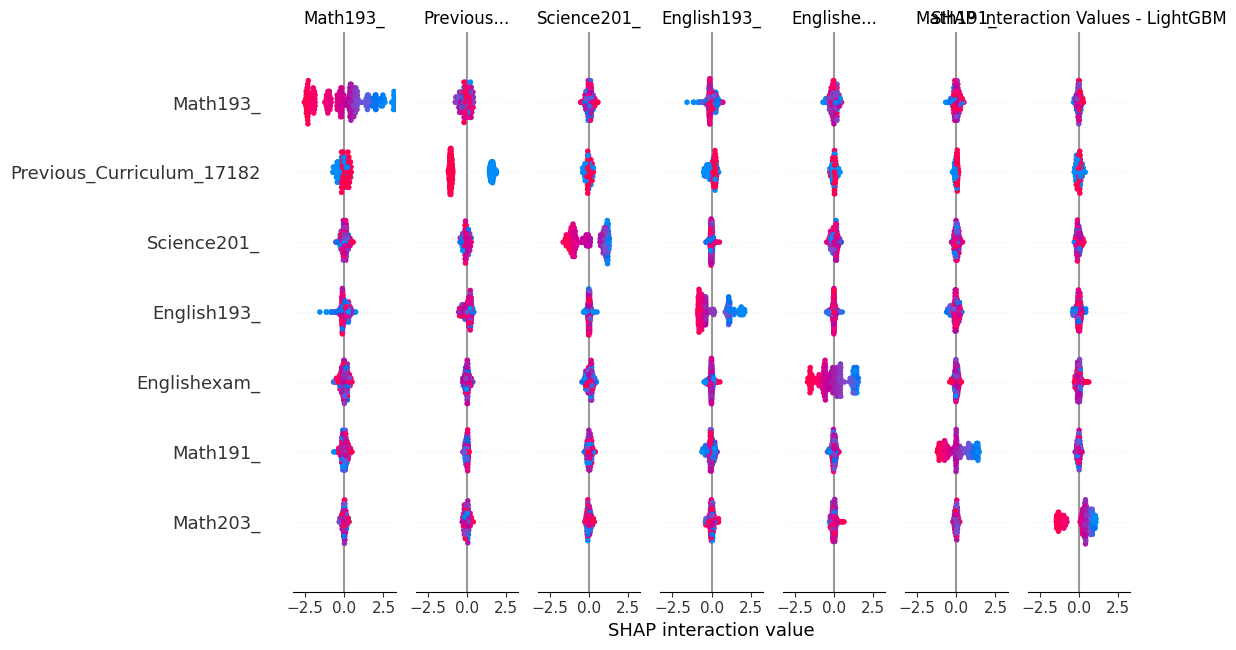


Generating SHAP interaction values for XGBoost...


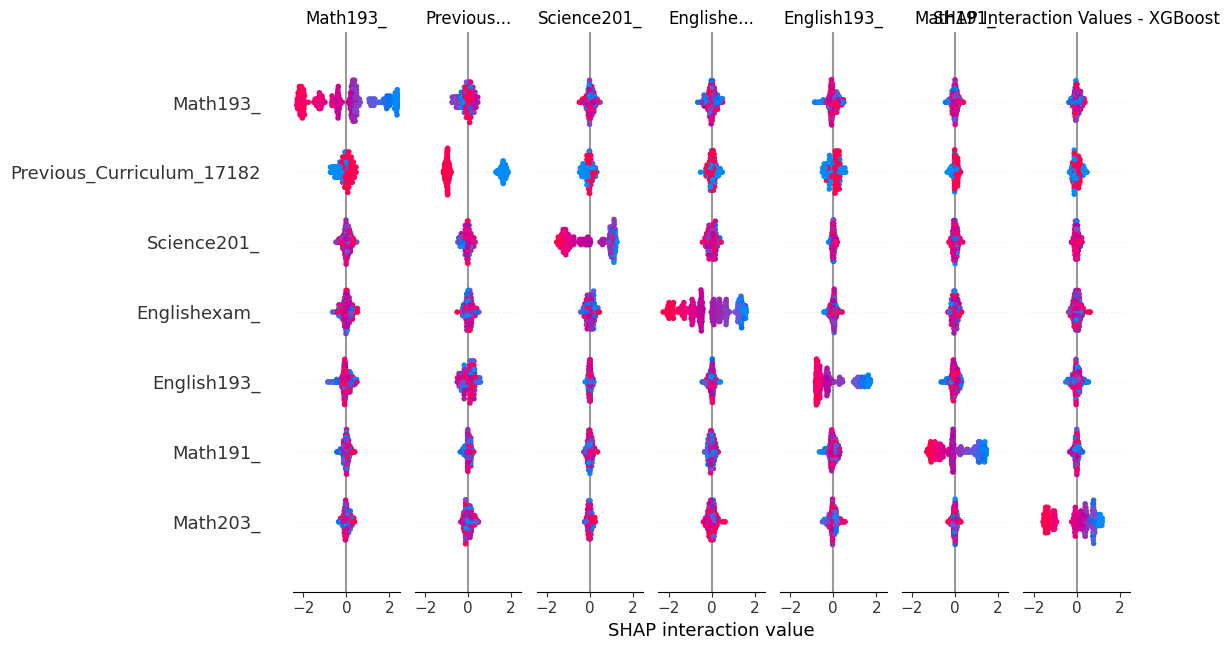

In [ ]:
# %%

# Step 5: SHAP Interaction Values for LightGBM and XGBoost

import shap
import matplotlib.pyplot as plt

for model_name in ['LightGBM', 'XGBoost']:
    print(f"\nGenerating SHAP interaction values for {model_name}...")
    
    explainer = shap.TreeExplainer(models[model_name])
    shap_interaction_values = explainer.shap_interaction_values(X_test)
    
    # Plot SHAP interaction summary
    shap.summary_plot(shap_interaction_values, X_test, plot_type="dot", show=False)
    plt.title(f"SHAP Interaction Values - {model_name}")
    plt.tight_layout()
    plt.savefig(f"The_Student_Dataset_SHAP_Interaction_{model_name}.png")
    plt.show()


Training surrogate decision tree for LightGBM...
LightGBM surrogate accuracy: 0.86


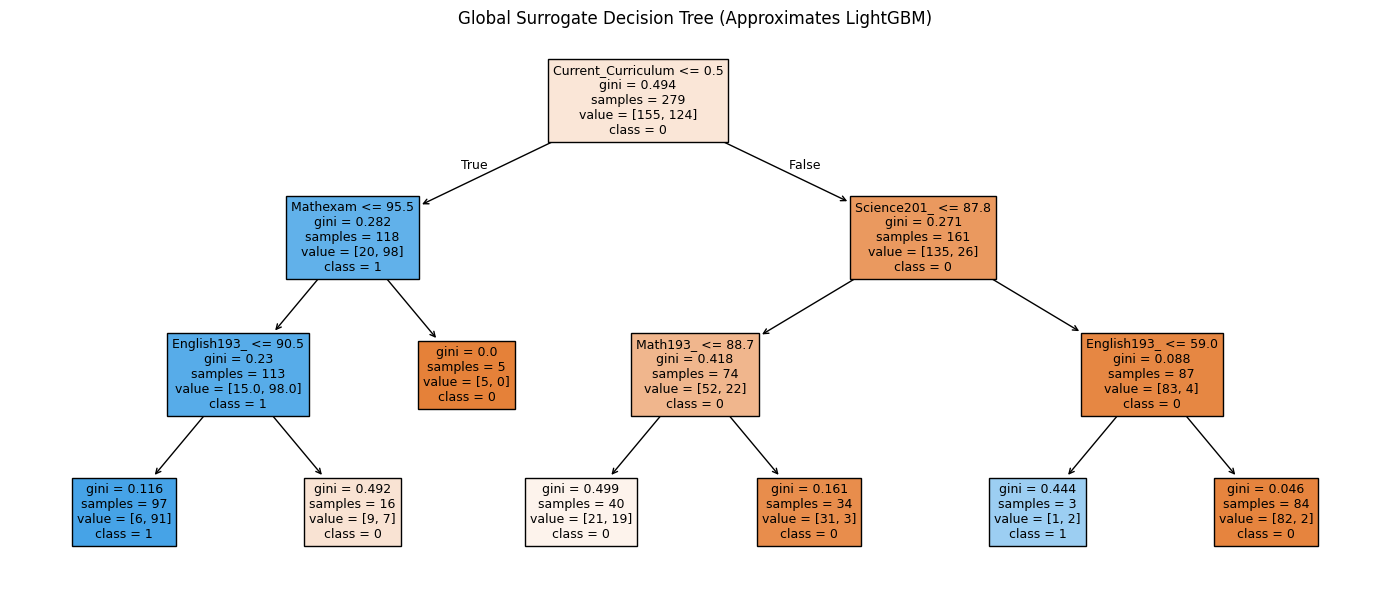


Training surrogate decision tree for XGBoost...
XGBoost surrogate accuracy: 0.89


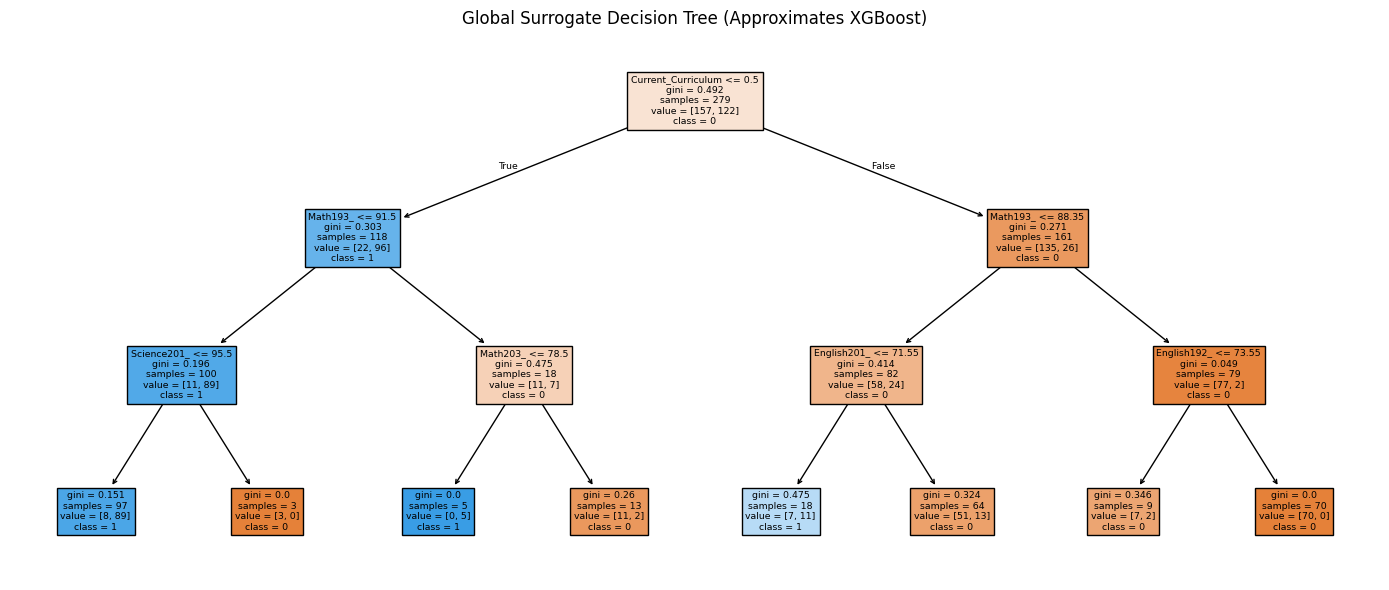

In [ ]:
# %%

# Step 6: Global Surrogate Model (Decision Tree) for LightGBM and XGBoost

from sklearn.tree import DecisionTreeClassifier, plot_tree

for model_name in ['LightGBM', 'XGBoost']:
    print(f"\nTraining surrogate decision tree for {model_name}...")

    # Get predictions from the black-box model
    y_pred_blackbox = models[model_name].predict(X_test)

    # Train the surrogate decision tree model
    surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
    surrogate.fit(X_test, y_pred_blackbox)

    # Accuracy of surrogate model
    surrogate_accuracy = surrogate.score(X_test, y_pred_blackbox)
    print(f"{model_name} surrogate accuracy: {surrogate_accuracy:.2f}")

    # Visualise the surrogate tree
    plt.figure(figsize=(14, 6))
    plot_tree(
        surrogate,
        feature_names=X.columns,
        class_names=[str(cls) for cls in surrogate.classes_],
        filled=True
    )
    plt.title(f"Global Surrogate Decision Tree (Approximates {model_name})")
    plt.tight_layout()
    plt.savefig(f"The_Student_Dataset_Global_Surrogate_{model_name}.png")
    plt.show()